In [1]:
%run lgs03a_data_unification.ipynb

### Correlation of mutation effects

SPEARMAN SpearmanrResult(correlation=0.8780584183051776, pvalue=8.9317e-320)
PEARSON (0.9554915410014464, 0.0)


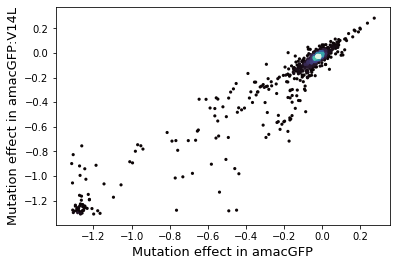

In [3]:
density_plot(np.array(df_effects_singles['effect_in_amac']), np.array(df_effects_singles['effect_in_amacV14L']),
            s=10, cmap='mako')
label_plot_axis(x='Mutation effect in amacGFP', y='Mutation effect in amacGFP:V14L')
print('SPEARMAN', scipy.stats.spearmanr(df_effects_singles['effect_in_amac'], df_effects_singles['effect_in_amacV14L'],
                           nan_policy='omit'))
print('PEARSON', scipy.stats.pearsonr(df_effects_singles[['effect_in_amac', 'effect_in_amacV14L']].dropna()['effect_in_amac'],
                           df_effects_singles[['effect_in_amac', 'effect_in_amacV14L']].dropna()['effect_in_amacV14L']))

### Difference in mutation effects by position

In [3]:
for gene in ['av','amac','cgre','pplu']:
    df_effects_singles['native_position_'+gene] = df_effects_singles['position'].apply(lambda x:
                                                pseudopos_to_nativepos[x][genekey[gene]])

In [4]:
for gene1 in ['av','amac','amacV14L','cgre','pplu']:
    for gene2 in ['av','amac','amacV14L','cgre','pplu']:
        if gene1==gene2:
            pass
        else:
            df_effects_singles['effect_'+gene1+'_minus_'+gene2] = df_effects_singles['effect_in_'+gene1] - df_effects_singles['effect_in_'+gene2]
            

In [5]:
def get_mutposeffect(data, y_column, x_val, x_column='position', s_column='mutation'):
    df = data[data[x_column]==x_val]
    return list(df[y_column]), list(df[s_column])

def set_x_coordinates(list_of_yvals, list_of_labels, y_distance_threshold, center_x, x_distance):
    '''Tries to find non-overlapping x coordinates for text-swarmplot'''
    yvals_to_labels = dict(zip(list_of_yvals, list_of_labels))
    list_of_yvals = sorted([x for x in list_of_yvals if str(x)!='nan'])
    list_of_xvals = [center_x for x in list_of_yvals]
    
    ref_y = 0
    multiplier = 1
#     original_x_distance = x_distance
    current_x_spacer = x_distance
        
    for i in range(1, len(list_of_yvals)):

        if abs(list_of_yvals[i] - list_of_yvals[ref_y]) < y_distance_threshold:
#             print(i, 'too close')
            list_of_xvals[i] += multiplier*current_x_spacer
            multiplier *= (-1)
            if multiplier== 1:
#                 print(i, 'multiply -1')
                current_x_spacer+=x_distance
        else:
            ref_y = i
            current_x_spacer = x_distance
#             print(i, 'new ref')

    return list_of_xvals, list_of_yvals, [yvals_to_labels[y] for y in list_of_yvals]

In [6]:
def plot_positional_difs(ref_gene, comp_gene, df = df_effects_singles, ylims=(-0.65,0.4),
                         colors = ['k','darkblue'], neutral_limit=0.075):
    
    plt.figure(figsize=[175,4], dpi=100)
    labels = ['%s\n%s\n' % (str(i),aa) for i,aa in enumerate(eval(ref_gene+'_wt'))]
    plt.xticks(range(0, len(labels)), labels)
    plt.xlim(-1, len(labels)+1)
    plt.ylim(ylims)
    label_plot_axis(x = 'Amino acid positions and wildtype states', fontsize_x = 16,
                    y = 'Difference in effect', fontsize_y = 14, fontsize_t = 18,
                    t = 'Difference in effect of single mutations: %s vs %s' % (ref_gene, comp_gene))
    plt.axhline(neutral_limit, color='r', linewidth=0.5)
    plt.axhline(-neutral_limit, color='r', linewidth=0.5)
    
    for pos in range(len(labels)):
        yvals, labels = get_mutposeffect(df, y_column='effect_'+comp_gene+'_minus_'+ref_gene, 
                                     x_column = 'native_position_'+ref_gene, x_val=pos)
        xvals, yvals, labels = set_x_coordinates(yvals, labels, y_distance_threshold=0.05, 
                                             center_x=pos, x_distance=0.15)
        for i in range(len(yvals)):
            plt.text(x = xvals[i] , y = yvals[i], s=labels[i], size='small', color=colors[pos%2],
                   verticalalignment='center', horizontalalignment='center', weight='semibold')

<Figure size 20000x600 with 0 Axes>

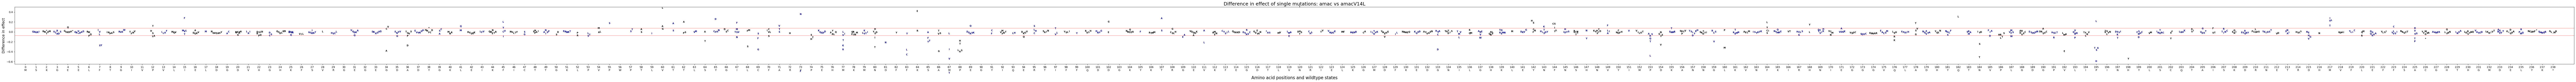

In [7]:
plt.figure(figsize=[100,3], dpi=200)
plot_positional_difs('amac','amacV14L', ylims=(-0.65,0.5))

C:\Users\lgonzale\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


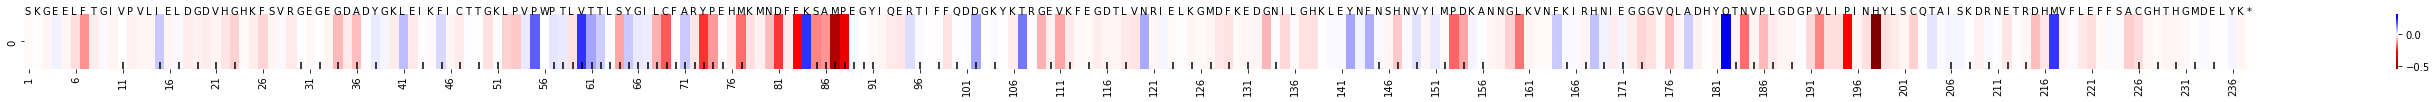

In [8]:
mean_differences_by_pos = get_effects_by_position('amac', df_effects_singles, positions='native', 
                                                  func=np.nanmean, col='effect_amacV14L_minus_')

plt.figure(figsize=[50,1])
sns.heatmap(np.array([mean_differences_by_pos[1:]]), cmap='seismic_r', center=0)
plt.scatter([x+0.5 for x in buried_pos], [1 for x in buried_pos], color='k', s=50, marker=2)
pos = [x+0.5 for x in range(len(mean_differences_by_pos))]
for index,aa in enumerate(amac_wt[1:]):
    plt.text(x=index, y=0, s=aa)
plt.xticks(pos[::5], range(1,len(mean_differences_by_pos),5));

### General sensitivity to mutations

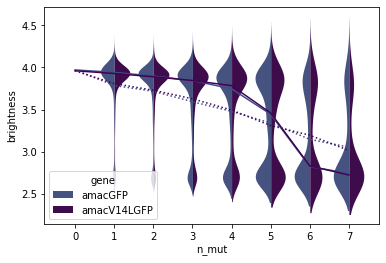

In [13]:
sns.violinplot(data=data_aa[(data_aa.n_mut<8) & (amacV14L_mask | amacV14V_mask)], 
               x='n_mut', hue='gene',y='brightness', 
               palette=[colors['amac'], colors['amacV14L']], split=True, linewidth=0)
plt.plot(range(8), [data_aa[amacV14V_mask & (data_aa.n_mut==i)]['brightness'].median() for i in range(8)],
        color=colors['amac'])
plt.plot(range(8), [data_aa[amacV14L_mask & (data_aa.n_mut==i)]['brightness'].median() for i in range(8)],
        color=colors['amacV14L'])
plt.plot(range(8), [data_aa[amacV14V_mask & (data_aa.n_mut==i)]['brightness'].mean() for i in range(8)],
        color=colors['amac'], linestyle=':')
plt.plot(range(8), [data_aa[amacV14L_mask & (data_aa.n_mut==i)]['brightness'].mean() for i in range(8)],
        color=colors['amacV14L'], linestyle=':')